In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import sys
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
GIT_ROOT = Path("../../..").resolve()
print(GIT_ROOT)
SRC = GIT_ROOT / "src"
if not SRC in sys.path:
    sys.path.append(str(SRC))

/home/ubuntu/KEX---CT-reconstruction


MSE original data: tensor(0.0053, device='cuda:0', dtype=torch.float64)
MSE full_series: tensor(0.0100, device='cuda:0', dtype=torch.float64)
MSE strict series: tensor(0.0156, device='cuda:0', dtype=torch.float64)

HTC score of threshholded reconstructions from original data: tensor([1., 1., 1., 1., 1.], device='cuda:0')
HTC score of threshholded reconstructions from full series : tensor([0.9988, 0.9979, 0.9967, 0.9969, 0.9983], device='cuda:0')
HTC score of threshholded reconstructions from strict series: tensor([0.9987, 0.9890, 0.9733, 0.9882, 0.9924], device='cuda:0')
Winning HTC score: 0.98965


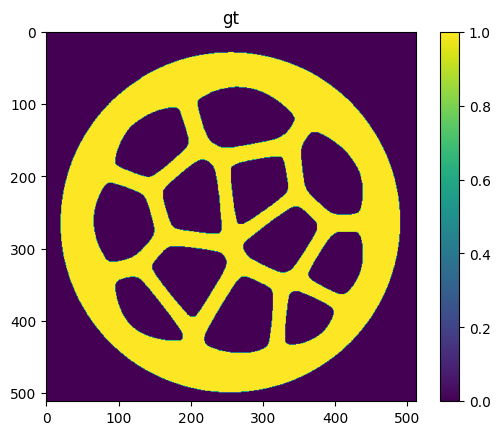

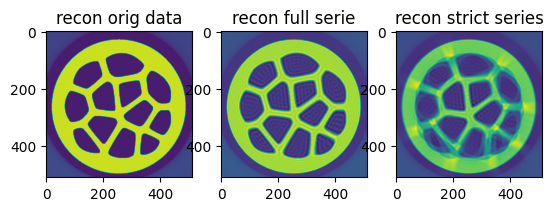

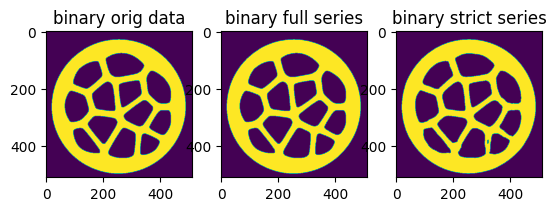

In [3]:
from utils.tools import htc_score, MSE
from utils.data import get_htc2022_train_phantoms
from utils.polynomials import Legendre, Chebyshev
from geometries import HTC2022_GEOMETRY, DEVICE, DTYPE, CDTYPE, get_moment_mask, enforce_moment_constraints

### Config
geometry = HTC2022_GEOMETRY
PHANTOMS = get_htc2022_train_phantoms()
SINOS = geometry.project_forward(PHANTOMS)

PolynomialFamily = Legendre
M, K = 128, 64 #number of polynomials and number of trig functions
winning_htc_score = 2.96895 / 3 #highest average score among three phantoms in test data that the winning team achieved
#https://www.fips.fi/HTC2022_results.pdf
disp_ind = 2
####

coefficients = geometry.series_expand(SINOS, PolynomialFamily, M, K)
strict_coefficients = coefficients.clone()
enforce_moment_constraints(strict_coefficients)
full_series = geometry.synthesise_series(coefficients, PolynomialFamily)
strict_series = geometry.synthesise_series(strict_coefficients, PolynomialFamily)

recons_orig = geometry.fbp_reconstruct(SINOS)
recons_full_series = geometry.fbp_reconstruct(full_series)
recons_strict_series = geometry.fbp_reconstruct(strict_series)

print("MSE original data:", MSE(recons_orig, PHANTOMS))
print("MSE full_series:", MSE(recons_full_series, PHANTOMS))
print("MSE strict series:", MSE(recons_strict_series, PHANTOMS))
print()
print("HTC score of threshholded reconstructions from original data:", htc_score(recons_orig>0.5, PHANTOMS.to(torch.bool)))
print("HTC score of threshholded reconstructions from full series :", htc_score(recons_full_series>0.5, PHANTOMS.to(torch.bool)))
print("HTC score of threshholded reconstructions from strict series:", htc_score(recons_strict_series>0.5, PHANTOMS.to(torch.bool)))
print("Winning HTC score:", winning_htc_score)

plt.title("gt")
plt.imshow(PHANTOMS[disp_ind].cpu())
plt.colorbar()
plt.show()

plt.figure()
plt.subplot(131)
plt.imshow(recons_orig[disp_ind].cpu())
plt.title("recon orig data")
plt.subplot(132)
plt.imshow(recons_full_series[disp_ind].cpu())
plt.title("recon full serie")
plt.subplot(133)
plt.imshow(recons_strict_series[disp_ind].cpu())
plt.title("recon strict series")
plt.show()

#Binary reconstructions
plt.figure()
plt.subplot(131)
plt.imshow(recons_orig[disp_ind].cpu()>0.5)
plt.title("binary orig data")
plt.subplot(132)
plt.imshow(recons_full_series[disp_ind].cpu()>0.5)
plt.title("binary full series")
plt.subplot(133)
plt.imshow(recons_strict_series[disp_ind].cpu()>0.5)
plt.title("binary strict series")

plt.show()

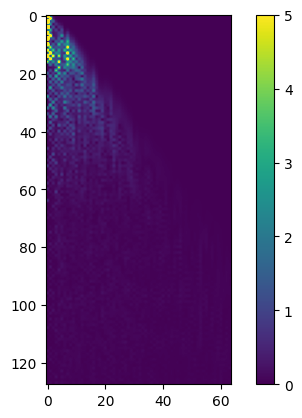

In [12]:
plt.imshow((coefficients.abs()[disp_ind].cpu()), vmin=0, vmax=5)
# plt.imshow(strict_coefficients.abs()[disp_ind].cpu())
plt.colorbar()
plt.show()